In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pandas_summary import DataFrameSummary

%matplotlib inline

In [2]:
DATA_PATH = pathlib.PosixPath('./data')

Load the 2015 dataset. Note that a number of fields from the original dataset that were deemed irrelevant to delay prediction have been dropped and departure and arrival times have been converted into minutes since midnight.

In [5]:
dfs = []
for month_idx in range(12):
    file_name = '2015-{0:02d}.csv'.format(month_idx + 1)
    path = DATA_PATH / file_name
    print('Loading {}'.format(path))
    df_month = pd.read_csv(path, low_memory=False)
    dfs.append(df_month)
    
df = pd.concat(dfs, ignore_index=True)
df.shape

Loading data/2015-01.csv
Loading data/2015-02.csv
Loading data/2015-03.csv
Loading data/2015-04.csv
Loading data/2015-05.csv
Loading data/2015-06.csv
Loading data/2015-07.csv
Loading data/2015-08.csv
Loading data/2015-09.csv
Loading data/2015-10.csv
Loading data/2015-11.csv
Loading data/2015-12.csv


(5819079, 39)

Drop rows for cancelled flights (since they have no meaningful delay data) and create boolean delay labels (where delay > 15 minutes)

In [49]:
df = df.drop(columns='Unnamed: 0')
df = df.loc[~(df['Cancelled'] == 1)]

df['DepartureIsDelayed'] = df['DepartureDelayGroups'] >= 1

Display some summary stats for the dataset.

In [51]:
summary = DataFrameSummary(df)

We can see that
- there is no missing data that relate directly to predicting departure delays. 
- there is a very small amount of data relating to arrival delays that is missing.
- Only a small amount of data relating to delay causes is populated.

In [52]:
summary.columns_stats.loc['missing_perc']

Year                                   0%
Quarter                                0%
Month                                  0%
DayofMonth                             0%
DayOfWeek                              0%
FlightDate                             0%
DOT_ID_Reporting_Airline               0%
Flight_Number_Reporting_Airline        0%
OriginAirportID                        0%
OriginCityMarketID                     0%
OriginState                            0%
DestAirportID                          0%
DestCityMarketID                       0%
DestState                              0%
CRSDepTime                             0%
DepTime                                0%
DepDelay                               0%
DepartureDelayGroups                   0%
WheelsOff                              0%
WheelsOn                            0.05%
TaxiIn                              0.05%
CRSArrTime                             0%
ArrTime                             0.05%
ArrDelay                          

Now we can look at the cardinality of the columns. Of the columns that we expect to be categorical, there are a large number (~7000) unique flight numbers (`Flight_Number_Reporting_Airline`) in particular.

In [55]:
summary.columns_stats.loc['uniques', :]

Year                                  1
Quarter                               4
Month                                12
DayofMonth                           31
DayOfWeek                             7
FlightDate                          365
DOT_ID_Reporting_Airline             14
Flight_Number_Reporting_Airline    6947
OriginAirportID                     322
OriginCityMarketID                  301
OriginState                          53
DestAirportID                       322
DestCityMarketID                    301
DestState                            53
CRSDepTime                         1320
DepTime                            1440
DepDelay                           1215
DepartureDelayGroups                 15
WheelsOff                          1440
WheelsOn                           1440
TaxiIn                              185
CRSArrTime                         1435
ArrTime                            1440
ArrDelay                           1240
ArrivalDelayGroups                   15


In [56]:
delayed_by_dow = pd.DataFrame(df.groupby(['DayOfWeek', 'DepartureIsDelayed']).size()).unstack(level=1)
delayed_by_dow.columns = ['not_delayed', 'delayed']
delayed_by_dow['total'] = delayed_by_dow.sum(axis=1)
delayed_by_dow['delay_ratio'] = delayed_by_dow['delayed'] / delayed_by_dow['total']

In [60]:
delayed_by_dow

,not_delayed,delayed,total,delay_ratio
DayOfWeek,,,,
1,679305,165165,844470,0.195584
2,679890,149638,829528,0.180389
3,694301,150867,845168,0.178505
4,693941,166288,860229,0.193307
5,691960,161443,853403,0.189176
6,578407,113389,691796,0.163905
7,655889,148710,804599,0.184825


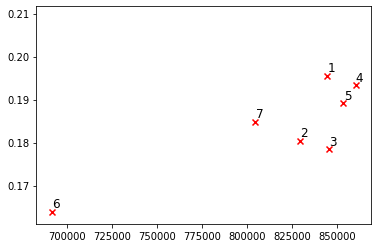

In [67]:
for i, dow in enumerate(delayed_by_dow.index.values):
    x = delayed_by_dow.at[dow, 'total']
    y = delayed_by_dow.at[dow, 'delay_ratio']
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x + 100, y + 0.001, dow, fontsize=12)
    
plt.show()

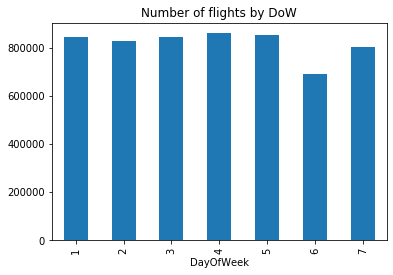

In [57]:
delayed_by_dow['total'].plot(kind='bar', title='Number of flights by DoW')

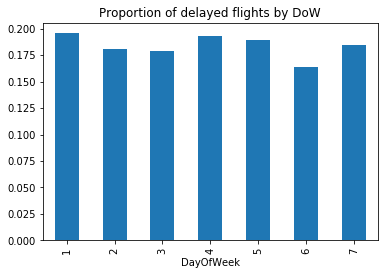

In [58]:
delayed_by_dow['delay_ratio'].plot(kind='bar', title='Proportion of delayed flights by DoW')

In [75]:
df_airlines = pd.read_csv(DATA_PATH / 'lookups' / 'airline_ids.csv', index_col='Code')

In [78]:
df_airlines.loc[19393, ]

Description    Southwest Airlines Co.: WN
Name: 19393, dtype: object

In [69]:
delayed_by_airline = pd.DataFrame(df.groupby(['DOT_ID_Reporting_Airline', 'DepartureIsDelayed']).size()).unstack(level=1)
delayed_by_airline.columns = ['not_delayed', 'delayed']
delayed_by_airline['total'] = delayed_by_airline.sum(axis=1)
delayed_by_airline['delay_ratio'] = delayed_by_airline['delayed'] / delayed_by_airline['total']

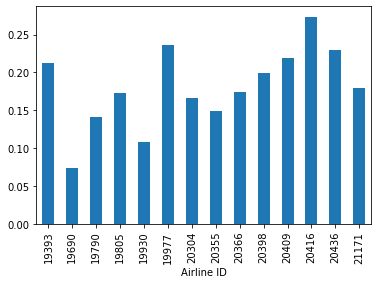

In [70]:
fig = plt.figure(figsize=(6, 4))
ax = delayed_by_airline['delay_ratio'].plot(kind='bar', title='', fig=fig)
ax.set_xlabel('Airline ID')
fig.savefig("fig_trend_airline.pdf", bbox_inches='tight')